# MAM Coagulation Verification Test

## Component Being Tested

Atmosphere, Modal Aerosol Model physics model, Coagulation

## Description

MAM tracks aerosol particle via modes, so that a single mode of particles can be described by just three terms: a number concentration magnitude ($N$), a median particle diameter ($D_m$), and a standard deviation ($\sigma$). So for a number concentration $N=10^8$, a median diameter $D_m=0.2 \times 10^{-6}$m, and a standard deviation $\sigma=1.8$m, the mode would look like this:

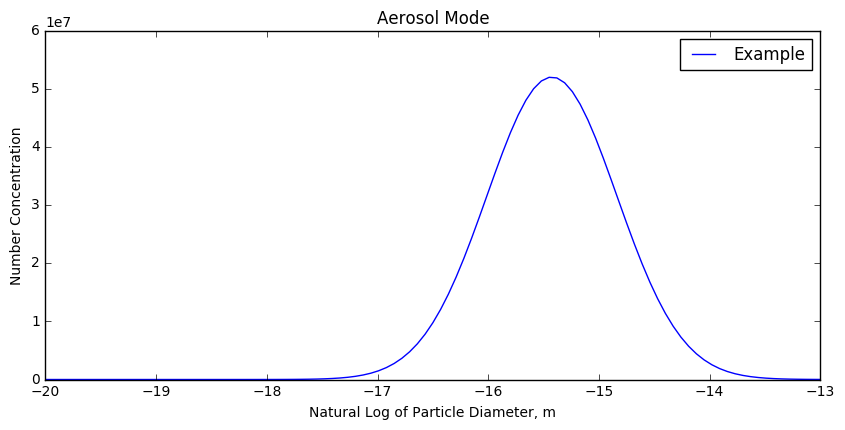

In [1]:
%matplotlib inline
import mam_util
mam_util.plot_single_mode(magnitude=1e8, median=0.2e-6, std_dev=1.8, label="Example")

MAM tracks **three** modes, refered to as the "Aitken" mode, the "Accumulation" mode and the "Primary Carbon" mode. For these three modes, the standard deviation is held fixed, but the number concentration magnitude and median particle diameters can vary over time. A composite of these modes at a typical distribution might look like this:

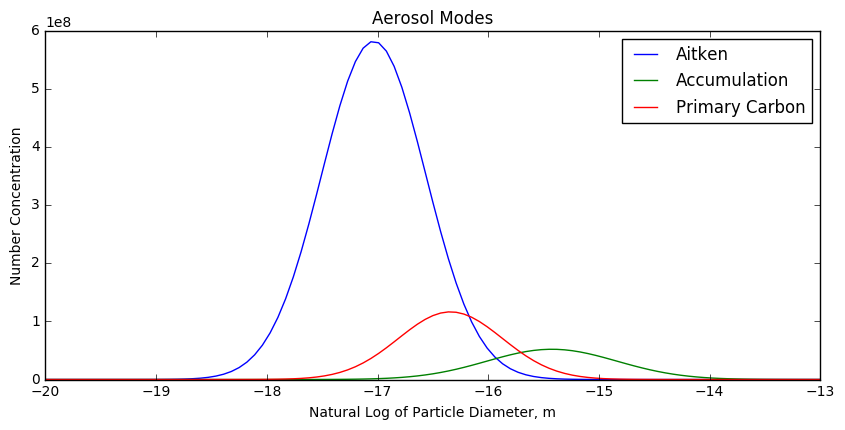

In [2]:
aitken = (1e9, 0.04e-6, 1.6, "Aitken")
accum  = (1e8, 0.20e-6, 1.8, "Accumulation")
pca    = (2e8, 0.08e-6, 1.6, "Primary Carbon")
mam_util.plot_three_modes(aitken, accum, pca)

## Variable Definitions

[This is a table of variable names and definitions. Variables that are discussed in the **Description** section should be defined here. Variables plotted (or otherwise displayed) in the **Results** section below should be defined here. Variables that help bridge from the **Description** to the **Results** should be defined here.]

$$
\begin{array}{ll}
    a         & \mbox{Definition of variable } a \\
    b         & \mbox{Definition of variable } b
\end{array}
$$

## Discussion

The "whats" and "whys" of specific verification test parameter choices should be discussed here. Figures can also be helpful, e.g.

In [9]:
from IPython.display import display, Image
#display(Image(filename='InitialHeightField.png'))

The **Description** should provide the mathematics behind the verification test. The **Discussion** should provide the necessary insight and specific details that would allow a competent researcher to reproduce those tests.

## Results

Here is the meat of the verification test. It *could* include building the test, running the test, or extracting data from a nightly test, possibly run on a different platform. Feel free to break this section down into sub-sections. This will probably be the most code-intensive part of the notebook (python, shell script, or other), although it is highly recommended to provide a high-level interface to the testing and analysis, to make it as easy to follow as possible.

In [ ]:
%matplotlib inline
# Etc., etc.